In [1]:
%matplotlib inline
import control
from control.matlab import *
import numpy as np
import matplotlib.pyplot as plt

def pole_plot(poles, title='Pole Map'):
    plt.title(title)
    plt.scatter(np.real(poles), np.imag(poles), s=50, marker='x')

    plt.axhline(y=0, color='black');
    plt.axvline(x=0, color='black');
    plt.xlabel('Re');
    plt.ylabel('Im');

# Tune Those Gains!

State space control requires that you fill in up to three gain matrices (K, L  & I), each potentially containing a number of elements. Given the heurism that goes into selecting PID gains (of which there are only three) tuning a state space controller can seem a bit daunting. Fortunately, the state space control framework includes a formal way to calculate gains to arrive at what is called a Linear Quadratic Regulator as well as a Linear Quadratic Estimator. 

The goal of this notebook will be to walk you through the steps necessary to formulate the gains for an LQR and LQE. Once we've arrived at some acceptable gains, you can cut and paste them directly into your arduino sketch and start controlling some cool, complex dynamic systems with hopefully less guesswork and gain tweaking than if you were use a PID controller.

We'll be working from the model for the cart pole system from the examples folder. This system has multiple outputs and is inherently unstable so it's a nice way of showing the power of state space control. Having said that, **this analysis can apply to any state space model**, so to adapt it your system, just modify the system matricies ($A,B,C,D$) and the and cost function weighting matrices ($ Q_{ctrl}, R_{ctrl}, Q_{est}, R_{est} $ ) and rerun the notebook.

## Cart Pole

You can find the details on the system modelling for the inverted pendulum [here](http://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling) but by way of a quick introduction, the physical system consists of a pendulum mounted on top of a moving cart shown below. The cart is fitted with two sensors that measure the angle of the stick and the displacement of the cart. The cart also has an actuator to apply a horizontal force on the cart to drive it forwards and backwards. The aim of the controller is to manipulate the force on the cart in order to balance the stick upright.

![output](http://ctms.engin.umich.edu/CTMS/Content/InvertedPendulum/System/Modeling/figures/pendulum.png)

The state for this system is defined as:

\begin{equation}
\mathbf{x} = [ cart \;displacement, \; cart \;velocity, \; stick \;angle, \; stick \;angular\; velocity ]^T
\end{equation}

and the state space model that describes this system is as follows:

In [2]:
A = [[0.0,   1.0,  0.0,   0.0 ],
     [0.0,  -0.18, 2.68,  0.0 ],
     [0.00,  0.00, 0.00,  1.00],
     [0.00, -0.45, 31.21, 0.00]]

B = [[0.00],
     [1.82],
     [0.00],
     [4.55]]

C = [[1, 0, 0, 0],[0,0,1,0]]

D = [[0],[0]]

## Take a look at the Open Loop System Poles

To get an idea of how this system behaves before we add any feedback control we can look at the poles of the open loop (uncontrolled) system. Poles are the roots of a characteristic equation derived from the system model. They're often complex numbers (having a real and an imaginary component) and are useful in understanding how the output of a system will respond to changes in its input.

There's quite a bit of interesting information that can be gleaned from looking at system poles but for now we'll focus on stability; which is determined by the pole with the largest real component (the x-axis in the plot below). If a system has any poles with positive real components then that system will be inherently unstable (i.e some or all of the state will shoot off to infinity if the system is left to its own devices).

The inverted pendulum has a pole at Re(+5.56) which makes sense when you consider that if the stick is stood up on its end and let go it'd fall over (obviously it'd stop short of infinity when it hits the side of the cart, but this isn't taken into account by the model). Using a feedback controller we'll move this pole over to the left of the imaginary axis in the plot below and in so doing, stabilise the system.


The poles of the open loop system are:

[ 5.56778052 -5.60644672 -0.14133379  0.        ]


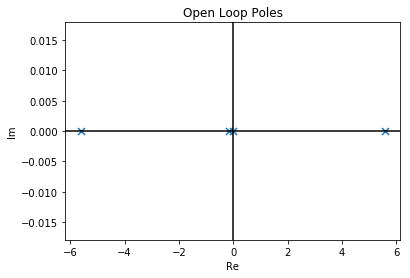

In [3]:
plant = ss(A, B, C, D)
open_loop_poles = pole(plant)

print '\nThe poles of the open loop system are:\n'
print open_loop_poles

pole_plot(open_loop_poles, 'Open Loop Poles')

# Design a Control Law

With a model defined, we can get started on calculating the gain matrix K (the control law) which determines the control input necessary to regulate the system state to $ \boldsymbol{0} $ (all zeros, you might want to control it to other set points but to do so just requires offsetting the control law which can be calculated on the arduino).

## Check for Controllability

For it to be possible to control a system defined by a given state space model, that model needs to be controllable. Being controllable simply means that the available set of control inputs are capable of driving the entire state to a desired set point. If there's a part of the system that is totally decoupled from the actuators that are manipulated by the controller then a system won't be controllable.

A system is controllable if the rank of the controllability matrix is the same as the number of states in the system model.

In [4]:
controllability = ctrb(A, B)

print 'The controllability matrix is:\n'
print controllability 

if np.linalg.matrix_rank(controllability) == np.array(B).shape[0]:
    print '\nThe system is controllable!'
else:
    print '\nThe system is not controllable, double-check your modelling and that you entered the system matrices correctly'

The controllability matrix is:

[[   0.            1.82         -0.3276       12.252968  ]
 [   1.82         -0.3276       12.252968     -4.40045424]
 [   0.            4.55         -0.819       142.15292   ]
 [   4.55         -0.819       142.15292     -31.0748256 ]]

The system is controllable!


## Fill out the Quadratic Cost Function

Assuming the system is controllable, we can get started on calculating the control gains. The approach we take here is to calculate a Linear Quadratic Regulator. An LQR is basically a control law (K matrix) that minimises the quadratic cost function:

\begin{equation}
J = \int_0^\infty (\boldsymbol{x}' Q \boldsymbol{x} + \boldsymbol{u}' R \boldsymbol{u})\; dt
\end{equation}

The best way to think about this cost function is to realise that whenever we switch on the state space controller, it'll expend some amount of control effort to bring the state to $ \boldsymbol{0} $ (all zeros). Ideally it'll do that as quickly and with as little overshoot as possible. We can represent that with the expression $ \int_0^\infty \boldsymbol{x}' \;\boldsymbol{x} \; dt $. Similarly it's probably a good idea to keep the control effort to a minimum such that the controller is energy efficient and doesn't damage the system with overly aggressive control inputs. This total control effort can be represented with $ \int_0^\infty \boldsymbol{u}' \;\boldsymbol{u} \; dt $.

Inevitably, there'll be some parts of the state and some control inputs that we care about minimising more than others. To reflect that in the cost function we specify two matrices; $ Q $ and $ R $

$ Q_{ctrl} \in \mathbf{R}^{X \;\times\; X} $ is the state weight matrix; the elements on its diagonal represent how important it is to tighly control the corresponding state element (as in Q[0,0] corresponds to x[0]).

$ R_{ctrl} \in \mathbf{R}^{U \;\times\; U} $ is the input weight matrix; the elements on its diagonal represent how important it is to minimise the use of the corresponding control input (as in R[0,0] corresponds to u[0]).

In [5]:
Q_ctrl = [[5000, 0, 0,   0],
          [0,    0, 0,   0],
          [0,    0, 100, 0],
          [0,    0, 0,   0]]

R_ctrl = [1]

## Calculate the Gain Matrix for a Linear Quadratic Regulator

With a cost function defined, the cell below will calculate the gain matrix K for an LQR. Bear in mind it usually takes a bit of tweaking of the cost function to arrive at a good K matrix. Also note that it's the relative value of each weight that's important, not their absolute values. You can multiply both $ Q_{ctrl} $ and $ R_{ctrl} $ by 1e20 and you'll still wind up with the same gains.

To guide your tweaking it's helpful to see the effect that different weightings have on the closed loop system poles. Remember that the further the dominant pole (largest real component) is to the left of the Im axis, the more stable your system will be. That said, don't get carried away and set ridiculously high gains; your actual system might not behave in exactly the same way as the model and an overly aggressive controller might just end up destabilising the system under realistic conditions.

The control gain is:

K =  [[ -70.71067812  -37.8232881   105.51674899   20.91640966]]

The poles of the closed loop system are:

[-8.49551966+7.93193591j -8.49551966-7.93193591j -4.76012015+0.83113826j
 -4.76012015-0.83113826j]


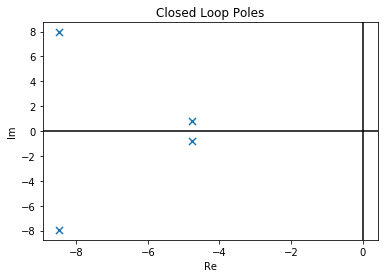

In [6]:
K, _, _ = lqr(A, B, Q_ctrl, R_ctrl)

print 'The control gain is:\n'
print 'K = ', K

plant_w_full_state_feedback = ss(A,
                                 B,
                                 np.identity(plant.states),
                                 np.zeros([plant.states, plant.inputs]))

controller = ss(np.zeros([plant.states, plant.states]),
                np.zeros([plant.states, plant.states]), 
                np.zeros([plant.inputs, plant.states]), 
                K)

closed_loop_system = feedback(plant_w_full_state_feedback, controller)
closed_loop_poles = pole(closed_loop_system)

print '\nThe poles of the closed loop system are:\n'
print closed_loop_poles

pole_plot(closed_loop_poles, 'Closed Loop Poles')

# Design an Estimator

If you're lucky enough to be able to directly observe the system's entire state (in which case the $ C $ matrix will be an identity matrix) then you're done!

This obviously isn't the case for the cart pole since given our sensors we aren't able to directly observe the cart velocity or the stick angular velocity (we can differentiate the sensor readings ofcourse, but doing so is a bad idea if the sensors are even a little bit noisy). Because of this, we'll need to introduce an estimator into the feedback controller to reconstruct those parts of the state based on our sensor readings $ \mathbf{y} $. 

There's a nice duality between the estimator and the controller so the basic approach we take to calculate the estimator gain ($ L $ matrix) are very similar those for the control law above.

## Check for Observability

Observability tells us whether the sensors we've attached to our system (as defined by the C matrix) are sufficient to derive an estimate of the state to feed into our control law. If for example, a part of the state was completely decoupled from all of the sensor measurements we take, then the system won't be observable and it'll be impossible to estimate and ultimately, to control.

Similar to controllability, a system is observable if the rank of the observability matrix is the same as the number of states in the model.

In [7]:
observability = obsv(A, C)

print 'The observability matrix is:\n'
print observability 

if np.linalg.matrix_rank(observability) == plant.states:
    print '\nThe system is observable!'
else:
    print '\nThe system is not observable, double-check your modelling and that you entered the matrices correctly'

The observability matrix is:

[[  1.       0.       0.       0.    ]
 [  0.       0.       1.       0.    ]
 [  0.       1.       0.       0.    ]
 [  0.       0.       0.       1.    ]
 [  0.      -0.18     2.68     0.    ]
 [  0.      -0.45    31.21     0.    ]
 [  0.       0.0324  -0.4824   2.68  ]
 [  0.       0.081   -1.206   31.21  ]]

The system is observable!


## Fill out the Noise Covariance Matrices

To calculate the estimator gain L, we can use the same algorithm as that used to calculate the control law. Again we define two matrices, $ Q $ and $ R $ however in this case their interpretations are slightly different.

$ Q_{est} \in \mathbf{R}^{X \;\times\; X} $ is referred to as the process noise covariance, it represents the accuracy of the state space model in being able to predict the next state based on the last state and the control input. It's assumed that the actual system is subject to some unknown noise which throws out the estimate of the state and in cases where that noise is very high, it's best to rely more heavily on the sensor readings.

$ R_{est}  \in \mathbf{R}^{Y \;\times\; Y} $ is referred to as the sensor noise covariance, it represents the accuracy of the sensor readings in being able to observe the state. Here again, it's assumed that the actual sensors are subject to some unknown noise which throws out their measurements. In cases where this noise is very high, it's best to be less reliant on sensor readings.

In [8]:
Q_est = [[100, 0,    0,    0   ],
         [0,    1000, 0,    0   ],
         [0,    0,    100, 0   ],
         [0,    0,    0,    10000]]

R_est = [[1,0],[0,1]]

## Calculate the Gain Matrix for a Linear Quadratic Estimator (aka Kalman Filter)

Ideally, the estimator's covariance matrices can be calculated empirically using data collected from the system's actual sensors and its model. Doing so is a bit outside of the scope of this notebook, so instead  we can just tweak the noise values to come up with an estimator that converges on the actual state with a reasonable settling time based on the closed loop poles.

The estimator gain is:

L =  [[  1.26107241e+01   2.09181219e-02]
 [  2.95153993e+01   2.33679588e+00]
 [  2.09181219e-02   1.92861410e+01]
 [ -1.66957337e+00   1.35977837e+02]]

The poles of the closed loop system are:

[-8.49551966+7.93193591j -8.49551966-7.93193591j -9.63985153+3.42895407j
 -9.63985153-3.42895407j -9.41774474+0.j         -4.76012015+0.83113826j
 -4.76012015-0.83113826j -3.37941729+0.j        ]


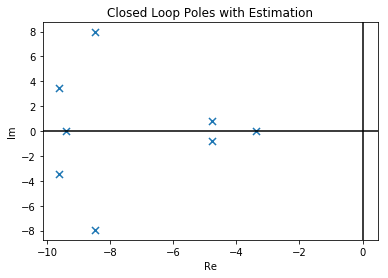

In [9]:
L, _, _ = lqr(np.array(A).T, np.array(C).T, Q_est, R_est)
L = L.T

print 'The estimator gain is:\n'
print 'L = ', L

controller_w_estimator = ss(A - np.matmul(B , K) - np.matmul(L , C), 
                            L,
                            K,
                            np.zeros([plant.inputs, plant.outputs]))

closed_loop_system_w_estimator = feedback(plant, controller_w_estimator)
closed_loop_estimator_poles = pole(closed_loop_system_w_estimator)

print '\nThe poles of the closed loop system are:\n'
print closed_loop_estimator_poles

pole_plot(closed_loop_estimator_poles, 'Closed Loop Poles with Estimation')

# And You're Done!

Congratulations! You've tuned an LQR and an LQE to suit your system model and you can now cut and paste the gains into your arduino sketch. 

## Coming soon, Integral Gain selection!